In [15]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [16]:
torch.__version__

'1.0.0.dev20181124'

In [27]:
trainPath = "/mnt/b405f74a-72c4-4e5a-8bd4-d763618331be/flower_data/train"
validationPath = "/mnt/b405f74a-72c4-4e5a-8bd4-d763618331be/flower_data/valid"

sizeOne = 256
sizeTwo = (224, 224)


traintransform = transforms.Compose([
    transforms.Resize(sizeOne),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

validationtransform = transforms.Compose([
    transforms.Resize(sizeTwo),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    #transforms.RandomCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainData = torchvision.datasets.ImageFolder(trainPath, transform=traintransform)

validationData = torchvision.datasets.ImageFolder(validationPath, transform=validationtransform)

In [28]:
batchSize = 64

traindataLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=batchSize,
                                          shuffle=True)

validationdataLoader = torch.utils.data.DataLoader(validationData, batch_size=batchSize)

In [29]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

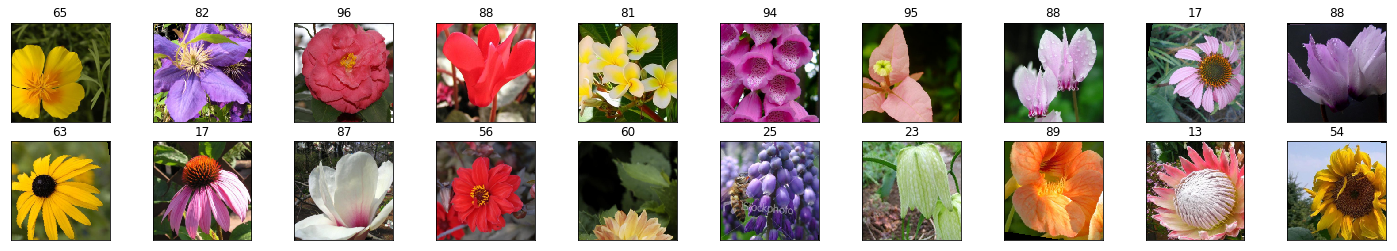

In [30]:
# obtain one batch of training images
traindataiter = iter(traindataLoader)
images, labels = traindataiter.next()
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainData.classes[labels[idx]])

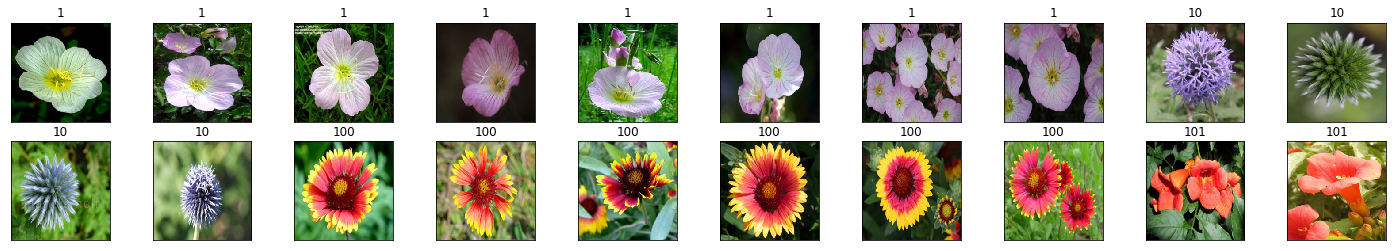

In [31]:
# obtain one batch of training images
validationdataiter = iter(validationdataLoader)
images, labels = validationdataiter.next()
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(validationData.classes[labels[idx]])

In [32]:
model = models.densenet201(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [37]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

fcLarge = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, 1024)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(1024, 512)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.2)),
    ('fc3', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

fcSmall = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.2)),
    ('fc3', nn.Linear(256, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = fcSmall

In [38]:
model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [39]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in traindataLoader:
        steps += 1
        
        model.train()
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            
            for images, labels in validationdataLoader:
                
                images, labels = images.cuda(), labels.cuda()
                
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validationdataLoader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validationdataLoader):.3f}")
            
            running_loss = 0
            model.train()
        
        
        
# Epoch 5/5.. Train loss: 0.192.. Test loss: 0.261.. Test accuracy: 0.945
# without random horizontal flip and random rotation
# with batch size 64, densenet201
# with fc as classifier
# with learning rate 0.001


# Epoch 5/5.. Train loss: 0.416.. Test loss: 0.352.. Test accuracy: 0.911
# without random horizontal flip and random rotation
# with batch size 64, densenet201
# with fcSmall as classifier
# with learning rate 0.001


# Epoch 5/5.. Train loss: 0.243.. Test loss: 0.342.. Test accuracy: 0.918
# with random horizontal flip and random rotation
# with batch size 64, densenet201
# with fc as classifier
# with learning rate 0.001
# This one started to overfit...


# Epoch 5/5.. Train loss: 0.340.. Test loss: 0.431.. Test accuracy: 0.903
# with random horizontal flip and random rotation
# with batch size 64, densenet201
# with fcSmall as classifier
# with learning rate 0.001




Epoch 1/5.. Train loss: 4.580.. Test loss: 4.545.. Test accuracy: 0.018
Epoch 1/5.. Train loss: 4.537.. Test loss: 4.465.. Test accuracy: 0.041
Epoch 1/5.. Train loss: 4.455.. Test loss: 4.392.. Test accuracy: 0.075
Epoch 1/5.. Train loss: 4.460.. Test loss: 4.321.. Test accuracy: 0.113
Epoch 1/5.. Train loss: 4.318.. Test loss: 4.210.. Test accuracy: 0.120
Epoch 1/5.. Train loss: 4.233.. Test loss: 4.069.. Test accuracy: 0.103
Epoch 1/5.. Train loss: 4.087.. Test loss: 3.917.. Test accuracy: 0.188
Epoch 1/5.. Train loss: 3.838.. Test loss: 3.751.. Test accuracy: 0.219
Epoch 1/5.. Train loss: 3.704.. Test loss: 3.554.. Test accuracy: 0.285
Epoch 1/5.. Train loss: 3.600.. Test loss: 3.360.. Test accuracy: 0.311
Epoch 1/5.. Train loss: 3.417.. Test loss: 3.171.. Test accuracy: 0.281
Epoch 1/5.. Train loss: 3.152.. Test loss: 2.913.. Test accuracy: 0.340
Epoch 1/5.. Train loss: 2.874.. Test loss: 2.779.. Test accuracy: 0.361
Epoch 1/5.. Train loss: 2.770.. Test loss: 2.573.. Test accuracy

In [ ]:
# get predictions function

